In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
img = cv2.imread("./data/img/travolta_cage.jpg")

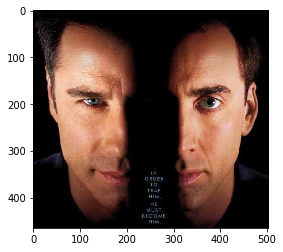

In [4]:
plt.imshow(img[:,:,::-1])

In [5]:
travolta = cv2.imread("./data/img/travolta.jpg")
cage = cv2.imread("./data/img/cage.jpg")

In [8]:
cage = cv2.resize(cage, (300, 300)) # Both pictures on the same size

**GOAL** Merge both into the same face.

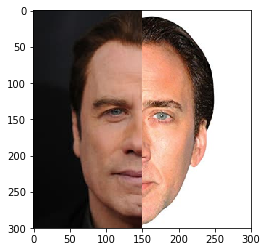

In [15]:
halves = np.hstack([travolta[:,0:150,:], cage[:,150:,:]])
plt.imshow(halves[:,:,::-1])


## Create a pyramid 

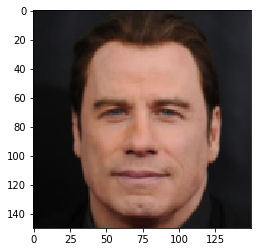

In [35]:
down = cv2.pyrDown(travolta) # Blurring + downsampling WITHOUT interpolation
plt.imshow(down[:,:,::-1])

In [17]:
down.shape

(150, 150, 3)

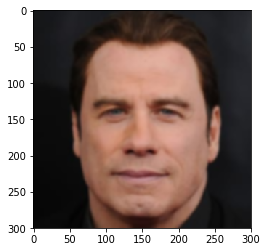

In [20]:
up = cv2.pyrUp(down)
plt.imshow(up[:,:,::-1])

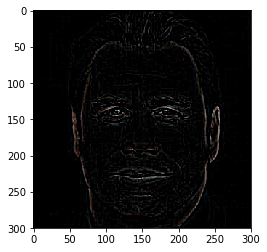

In [34]:
diff = cv2.subtract(travolta,up)
plt.imshow(5*diff[:,:,::-1]) # Make white more visible

In [32]:
np.sum(diff>0)

76555

### 1. Create downwards pyramid of both images


In [36]:
gp_travoltas = [travolta]
t = travolta.copy()
for _ in range(6):
    t = cv2.pyrDown(t)
    gp_travoltas.append(t)

In [41]:
gp_cage = [cage]
t = cage.copy()
for _ in range(6):
    t = cv2.pyrDown(t)
    gp_cage.append(t)

### 2. Find the Laplacian pyramid, (edges from reconstructed - actual)

In [56]:
laplacian_travoltas = [gp_travoltas[6]]

for i in range(6,0,-1):
    size = (gp_travoltas[i-1].shape[1], gp_travoltas[i-1].shape[0]) # size for up-rec
    reconstructed = cv2.pyrUp(gp_travoltas[i], dstsize = size) # Step-up
    laplacian = cv2.subtract(gp_travoltas[i-1], reconstructed)
    laplacian_travoltas.append(laplacian)

In [57]:
laplacian_cage = [gp_cage[6]]
for i in range(6,0,-1):
    size = (gp_cage[i-1].shape[1], gp_cage[i-1].shape[0]) # size for up-rec
    reconstructed = cv2.pyrUp(gp_cage[i], dstsize = size) # Step-up
    laplacian = cv2.subtract(gp_cage[i-1], reconstructed)
    laplacian_cage.append(laplacian)

In [58]:
[ t.shape for t in laplacian_travoltas]

[(5, 5, 3),
 (10, 10, 3),
 (19, 19, 3),
 (38, 38, 3),
 (75, 75, 3),
 (150, 150, 3),
 (300, 300, 3)]

### 3. Merge the edge maps 

In [59]:
merged = []

for t, c in zip(laplacian_travoltas, laplacian_cage):
    rows, cols, _ = t.shape
    ix = cols//2 # = int(cols/2)
    ls = np.hstack([t[:,:ix,:], c[:,ix:,:]]) # glueing the image as in the beginning
    merged.append(ls)    

In [60]:
merged[0].shape

(5, 5, 3)

### 4. Go all the way up, reconstruct and add the edges

In [65]:
rec = merged[0]
for i in range(1,7):
    size = (merged[i].shape[1], merged[i].shape[0])
    rec = cv2.pyrUp(rec, dstsize=size) # Reconstruct upwards
    rec = cv2.add(rec, merged[i]) # Add the edges

In [66]:
rec.shape

(300, 300, 3)

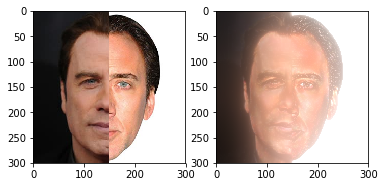

In [68]:
plt.subplot(121)
plt.imshow(halves[:,:,::-1])
plt.subplot(122)
plt.imshow(rec[:,:,::-1])

In [73]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


C:\Users\HP\Anaconda3\envs\opencv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rec', 'size', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


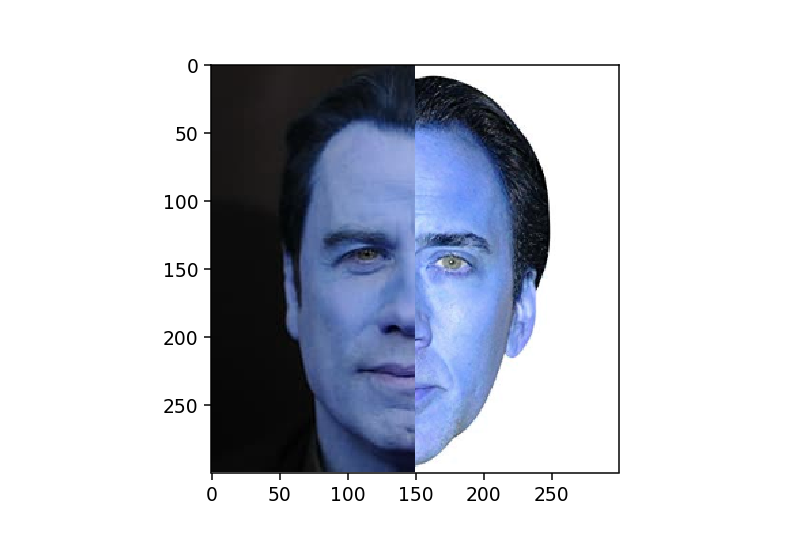

In [74]:
plt.imshow(halves);